In [37]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
from mosestokenizer import *

from sklearn.metrics import classification_report, confusion_matrix

import tensorflow as tf
from tensorflow import Tensor, keras
import tensorflow_hub as hub
from tensorflow.keras.layers import MultiHeadAttention, LayerNormalization, Dropout, Layer
from tensorflow.keras.layers import Embedding, Input, GlobalAveragePooling1D, Dense, TextVectorization
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.utils import to_categorical
import keras_tuner

import warnings
warnings.filterwarnings('ignore', category=np.VisibleDeprecationWarning)

# nltk.download('maxent_ne_chunker')
# nltk.download('words')
# nltk.download('punkt')
# nltk.download('stopwords')
# nltk.download('wordnet')
# nltk.download('averaged_perceptron_tagger')

In [3]:
df = pd.read_csv('../preprocessed_text/unprocessed_train.csv').sample(frac=1)
df_test = pd.read_csv('../preprocessed_text/unprocessed_test.csv')

X_train_text = df['Text']
X_test_text = df_test['Text']
y_train_categories = df['Verdict']
y_test_categories = df_test['Verdict']

# Data Analysis

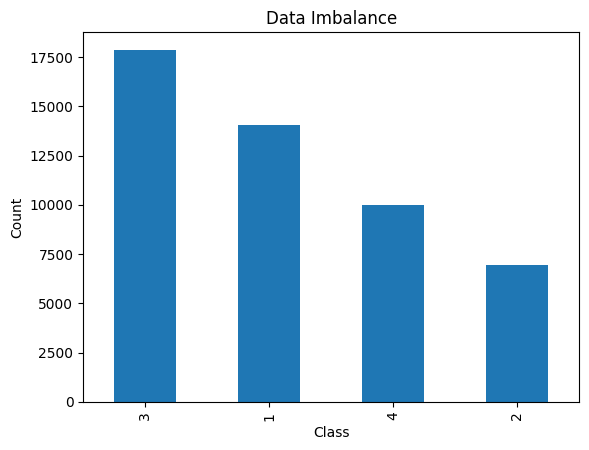

In [4]:
# Count the occurrences of each unique value in y_train
value_counts = y_train_categories.value_counts()

# Plot the data imbalance in a bar chart
value_counts.plot(kind='bar')

# Add labels and title
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Data Imbalance')

# Display the bar chart
plt.show()

In [5]:
df.head()

,Verdict,Text,Preprocessed Text
38288,3,The US Is Now the United (Police) State of Ame...,The US Is Now the United (Police) State of Ame...
7389,1,Days after San Francisco 49ers kicker David Ak...,Days after San Francisco 49ers kicker David Ak...
23841,3,Cover Up Mainstream Reporting on Fukushima a J...,Cover Up Mainstream Reporting on Fukushima a J...
35956,3,NBC Pulls Reporter From Gaza For Reporting Tru...,NBC Pulls Reporter From Gaza For Reporting Tru...
28818,3,A Century Ago: Rockefellers Funded Eugenics In...,A Century Ago: Rockefellers Funded Eugenics In...


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 48854 entries, 38288 to 7628
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Verdict            48854 non-null  int64 
 1   Text               48854 non-null  object
 2   Preprocessed Text  48854 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.5+ MB


# Preprocess text

In [18]:
def lowercase(text: Tensor) -> Tensor:
  return tf.strings.lower(text)

def remove_numbers(text: Tensor) -> Tensor:
  return tf.strings.regex_replace(text, '[0-9]', '')

def remove_punctuations(text: Tensor) -> Tensor:
  return tf.strings.regex_replace(text, '[%s]' % re.escape('!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'), '')

def add_start_and_end_tokens(text: Tensor) -> Tensor:
  START_TOKEN = tf.constant('<S>')
  END_TOKEN = tf.constant('</S>')
  return tf.strings.join([START_TOKEN, text, END_TOKEN], separator=' ')

def preprocess_text(text: Tensor) -> Tensor:
  text = lowercase(text)
  text = remove_numbers(text)
  text = remove_punctuations(text)
  text = add_start_and_end_tokens(text)
  return text

# Vectorize layer

In [20]:
vocab_size = 10000
max_length = 128

In [21]:
vectorize_layer = TextVectorization(
    standardize=preprocess_text,
    max_tokens=vocab_size,
    output_mode='int',
    output_sequence_length=max_length,
  )

In [22]:
vectorize_layer.adapt(X_train_text.to_list())

In [23]:
vectorize_layer.vocabulary_size()

10000

In [24]:
vectorize_layer(X_train_text[0])

<tf.Tensor: shape=(128,), dtype=int64, numpy=
array([  61,    6,  229,  311,   70,    6, 1448,  356, 5763, 1349,   49,
       7788,   14,    6,    1,    4, 1080,  136,  503,   36,   11,  672,
        353,  535,    8,   10,    2, 7493, 5270,  110, 8673, 1071,   19,
         48, 3804,   51,   14,  114,    1, 1859,    4,   30, 1070,    7,
       3106,   12,  526,   66,   59, 2271, 2547, 1156, 3699,    5,   32,
       8474, 5694,   49, 2653,    2, 5459, 1976,  254,  269, 5763, 1773,
          5,    1, 6159, 1907, 5402,    1,   29, 1420,  193,  142, 2735,
          2,  103, 1581,   47,  202,  551,    5, 1309,   30, 1070,   36,
        193, 1274,    3,  106, 1965,  171,    1, 5763, 2196, 7611, 1965,
         36,  450, 5402,  849,  142,  525,    3, 2683,   30, 4853,    1,
        443, 4419,   19,  890,    8,   53, 4854, 3054,   58,    1,    2,
       8673,   33,  438,    2,  560,  993, 1681])>

# Model components

In [25]:
class TransformerBlock(Layer):
  def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
    super(TransformerBlock, self).__init__()
    self.att = MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
    self.ffn = Sequential(
        [Dense(ff_dim, activation="relu"), 
          Dense(embed_dim),]
    )
    self.layernorm1 = LayerNormalization(epsilon=1e-6)
    self.layernorm2 = LayerNormalization(epsilon=1e-6)
    self.dropout1 = Dropout(rate)
    self.dropout2 = Dropout(rate)

  def call(self, inputs, training=False):
    attn_output = self.att(inputs, inputs)
    attn_output = self.dropout1(attn_output, training=training)
    out1 = self.layernorm1(inputs + attn_output)
    ffn_output = self.ffn(out1)
    ffn_output = self.dropout2(ffn_output, training=training)
    return self.layernorm2(out1 + ffn_output)

In [26]:
class TokenAndPositionEmbedding(Layer):
  def __init__(self, maxlen, vocab_size, embed_dim):
    super(TokenAndPositionEmbedding, self).__init__()
    self.token_emb = Embedding(input_dim=vocab_size, output_dim=embed_dim)
    self.pos_emb = Embedding(input_dim=maxlen, output_dim=embed_dim)

  def call(self, x):
    maxlen = tf.shape(x)[-1]
    positions = tf.range(start=0, limit=maxlen, delta=1)
    positions = self.pos_emb(positions)
    x = self.token_emb(x)
    return x + positions

# Glove 

In [27]:
# Creating a dictionary to store the embeddings
path_to_glove_file = '../GloVe/glove.twitter.27B.100d.txt'

embeddings_index = {}
with open(path_to_glove_file) as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs

print("Found %s word vectors." % len(embeddings_index))

Found 1193515 word vectors.


In [28]:
# Convert the embeddings to a matrix
vocab = vectorize_layer.get_vocabulary()
word_index = dict(zip(vocab, range(len(vocab))))
num_tokens = len(vocab) + 2
embed_dim = 100 # GloVe embeddings come in 100 dimensions

hits = 0
misses = 0

# Prepare embedding matrix
embedding_matrix = np.zeros((num_tokens, embed_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in embedding index will be all-zeros.
        # This includes the representation for "padding" and "OOV"
        embedding_matrix[i] = embedding_vector
        hits += 1
    else:
        misses += 1
print("Converted %d words (%d misses)" % (hits, misses))

Converted 9855 words (145 misses)


In [29]:
class PreTrainedVectorizationAndPositionEmbedding(Layer):
  def __init__(self, maxlen, vocab_size, embed_dim, embedding_matrix, trainable=False):
    super(PreTrainedVectorizationAndPositionEmbedding, self).__init__()
    self.embedding_matrix = embedding_matrix
    self.token_emb = Embedding(input_dim=vocab_size, output_dim=embed_dim, trainable=trainable)
    self.token_emb.build((1,))
    self.token_emb.set_weights([embedding_matrix])
    self.pos_emb = Embedding(input_dim=maxlen, output_dim=embed_dim)

  def call(self, x):
    maxlen = tf.shape(x)[-1]
    positions = tf.range(start=0, limit=maxlen, delta=1)
    positions = self.pos_emb(positions)
    x = self.token_emb(x)
    return x + positions

  def get_config(self):
        config = super(PreTrainedVectorizationAndPositionEmbedding, self).get_config()
        config.update({
            'embedding_matrix': self.embedding_matrix,  # Make sure to convert to numpy array if it's a TensorFlow tensor
        })
        return config

In [38]:
vocab_size = 10000  # Vocabulary size
max_length = 128  # Maximum length of token sequence
num_heads = 2  # Number of attention heads
ff_dim = 32  # Hidden layer size in feed forward network inside transformer
dropout_rate = 0.3  # Dropout rate
hidden_units = 32  # Number of neurons in feed forward network
output_dim = 4  # Number of classes

inputs = Input(shape=(1,), dtype=tf.string)
x = vectorize_layer(inputs)
embedding_layer = PreTrainedVectorizationAndPositionEmbedding(
  max_length,
  num_tokens,
  embed_dim,
  embedding_matrix,
  trainable=True
)
x = embedding_layer(x)
transformer_block = TransformerBlock(embed_dim, num_heads, ff_dim)
x = transformer_block(x, training=True)
x = GlobalAveragePooling1D()(x)
x = Dropout(dropout_rate)(x)
x = Dense(hidden_units, activation="relu")(x)
x = Dropout(dropout_rate)(x)
outputs1 = Dense(output_dim, activation="softmax")(x)

model = Model(inputs=inputs, outputs=outputs1)

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 1)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ text_vectorization_1            │ (None, 128)            │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pre_trained_vectorization_and_… │ (None, 128, 100)       │     1,013,000 │
│ (PreTrainedVectorizationAndPos… │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_block_2             │ (None, 128, 100)       │        87,632 │
│ (TransformerBlock)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_2      │ (None, 100)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 32)             │         3,232 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 4)              │           132 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,103,996 (4.21 MB)

 Trainable params: 1,103,996 (4.21 MB)

 Non-trainable params: 0 (0.00 B)

In [31]:
# X_train = vectorize_layer(X_train_text)
# X_test = vectorize_layer(X_test_text)

X_train = X_train_text
X_test = X_test_text

In [32]:
y_train_zero_based = y_train_categories - 1
y_test_zero_based = y_test_categories - 1

y_train = to_categorical(y_train_zero_based, num_classes=output_dim)
y_test = to_categorical(y_test_zero_based, num_classes=output_dim)

In [36]:
batch_size = 16  # Batch size for training
epochs = 3  # Number of complete passes through the dataset

model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(X_test, y_test))

Epoch 1/3
3054/3054 ━━━━━━━━━━━━━━━━━━━━ 48s 15ms/step - accuracy: 0.7838 - loss: 0.5666 - val_accuracy: 0.6387 - val_loss: 1.2348
Epoch 2/3
3054/3054 ━━━━━━━━━━━━━━━━━━━━ 46s 15ms/step - accuracy: 0.9586 - loss: 0.1306 - val_accuracy: 0.6293 - val_loss: 1.4400
Epoch 3/3
3054/3054 ━━━━━━━━━━━━━━━━━━━━ 46s 15ms/step - accuracy: 0.9741 - loss: 0.0841 - val_accuracy: 0.6523 - val_loss: 1.4876


In [ ]:
# Save model
model.save('../models/GloVe_default_transformer.keras')

# Hyperparameter tuning

In [39]:
def build_model(hp: keras_tuner.HyperParameters):
  vocab_size = 10000  # Vocabulary size
  max_length = 128  # Maximum length of token sequence
  num_heads = hp.Int("attention_head", min_value=2, max_value=4, step=1)  # Number of attention heads
  ff_dim = hp.Int("ff_dim", min_value=16, max_value=64, step=16)  # Hidden layer size in feed forward network inside transformer
  dropout_rate = hp.Float("dr", min_value=0.2, max_value=0.6, sampling="log")  # Dropout rate
  hidden_units = hp.Int("units", min_value=16, max_value=64, step=16)  # Number of neurons in feed forward network
  output_dim = 4  # Number of classes
  learning_rate = hp.Float("lr", min_value=1e-4, max_value=1e-2, sampling="log")

  inputs = Input(shape=(1,), dtype=tf.string)
  x = vectorize_layer(inputs)
  embedding_layer = PreTrainedVectorizationAndPositionEmbedding(
    max_length,
    num_tokens,
    embed_dim,
    embedding_matrix,
    trainable=True
  )
  x = embedding_layer(x)
  transformer_block = TransformerBlock(embed_dim, num_heads, ff_dim)
  x = transformer_block(x, training=True)
  x = GlobalAveragePooling1D()(x)
  x = Dropout(dropout_rate)(x)
  x = Dense(hidden_units, activation="relu")(x)
  x = Dropout(dropout_rate)(x)
  outputs1 = Dense(output_dim, activation="softmax")(x)

  model = Model(inputs=inputs, outputs=outputs1)

  model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
    loss='categorical_crossentropy',
    metrics=['accuracy']
  )

  return model

In [40]:
build_model(keras_tuner.HyperParameters())

<Functional name=functional_11, built=True>

In [41]:
tuner = keras_tuner.RandomSearch(
    hypermodel=build_model,
    objective="val_accuracy",
    max_trials=32,
    executions_per_trial=1,
    overwrite=True,
    directory="./models/base_transformer",
    project_name="base_transformer",
)

In [42]:
tuner.search_space_summary()

Search space summary
Default search space size: 5
attention_head (Int)
{'default': None, 'conditions': [], 'min_value': 2, 'max_value': 4, 'step': 1, 'sampling': 'linear'}
ff_dim (Int)
{'default': None, 'conditions': [], 'min_value': 16, 'max_value': 64, 'step': 16, 'sampling': 'linear'}
dr (Float)
{'default': 0.2, 'conditions': [], 'min_value': 0.2, 'max_value': 0.6, 'step': None, 'sampling': 'log'}
units (Int)
{'default': None, 'conditions': [], 'min_value': 16, 'max_value': 64, 'step': 16, 'sampling': 'linear'}
lr (Float)
{'default': 0.0001, 'conditions': [], 'min_value': 0.0001, 'max_value': 0.01, 'step': None, 'sampling': 'log'}


In [43]:
tuner.search(X_train, y_train, epochs=1, batch_size=16, validation_data=(X_test, y_test))

Trial 32 Complete [00h 00m 50s]
val_accuracy: 0.5263333320617676

Best val_accuracy So Far: 0.6743333339691162
Total elapsed time: 00h 26m 46s


In [44]:
# best 3
for trial in tuner.get_best_hyperparameters(num_trials=3):
  print(trial.values)

{'attention_head': 3, 'ff_dim': 64, 'dr': 0.4080434344775511, 'units': 32, 'lr': 0.0004886857620383402}
{'attention_head': 2, 'ff_dim': 32, 'dr': 0.26779721487722047, 'units': 64, 'lr': 0.0005048329912883117}
{'attention_head': 3, 'ff_dim': 48, 'dr': 0.3111295786601789, 'units': 16, 'lr': 0.0005144475412729949}


In [46]:
model = tuner.get_best_models(num_models=1)[0]

/home/bizon/miniconda3/envs/project55/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:418: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 46 variables. 
  trackable.load_own_variables(weights_store.get(inner_path))


# Model Scoring

In [47]:
model.evaluate(X_test, y_test)

94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.6054 - loss: 1.2755


[1.0730469226837158, 0.6743333339691162]

In [48]:
# Accuracy, Precision, Recall, F1 Score for Training Data
y_pred = model.predict(X_train)
y_pred = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_train, axis=1)
print(classification_report(y_true, y_pred))

 458/1527 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step

In [ ]:
# Confusion matrix for Training Data
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
# Accuracy, Precision, Recall, F1 Score for Testing Data
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)
print(classification_report(y_true, y_pred))

In [ ]:
# Confusion matrix for Testing Data
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()